In [2]:
import pandas as pd
import numpy as np
import scipy.optimize as optimize
import os
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import sklearn.metrics
import math
import datetime
import warnings
import plotly.express as px
import plotly.figure_factory as ff
import seaborn as sns
import xgboost as xgb
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from ipywidgets import HBox, VBox
from tabulate import tabulate
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from xgboost import plot_importance, plot_tree
#Matplotlib style
plt.style.use('fivethirtyeight')
#Ignoring some warnings
warnings.filterwarnings('ignore')

C:\Users\boyan\Anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [122]:
inputs = pd.read_csv(r'../Data/all_inputs_cleaned.csv')
outputs = pd.read_csv(r'../Data/all_outputs_cleaned.csv')

# Prediction for Construction

In [123]:
fig = px.line(outputs['Construction'], width=1000, height=500)
fig.update_layout(title_text='Monthly employment data of Construction from 2006-06-01 to 2023-09-01')
fig.show()

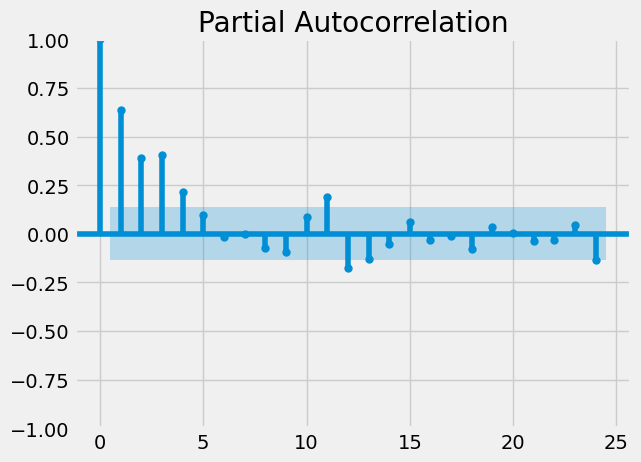

In [124]:
#This code uses the pacf() function from the tsa.stattools module of the statsmodels library (sm) to compute the autocorrelation function.
plot_pacf(outputs['Construction'],method="yw")
#Print the visualization
plt.show()

In [125]:
const_data = outputs[['Month','Construction']]
#Convert the date column to datetime format
const_data["Month"] = pd.to_datetime(const_data["Month"])
for i in range(1,5):
    const_data['prev'+str(i)]=const_data['Construction'].shift(i)
train_ml, test_ml, y_train, y_test = train_test_split(const_data, const_data['Construction'], test_size=0.3, random_state=0)

In [126]:
N = len(inputs.keys())
for i in range(2,N):
    key = inputs.keys()[i]
    for i in range(1,6):
        inputs[key + '_prev' + str(i)] = inputs[key].shift(i)
N = len(inputs.keys())
inputs.head()

,Unnamed: 0,Month,CPI,InterestRate,GDP,ValAddConst,ValAddInfo,Borrowing,CommercialLoan,ConsumerLoan,...,S&P500Price_prev1,S&P500Price_prev2,S&P500Price_prev3,S&P500Price_prev4,S&P500Price_prev5,S&P500Vol_prev1,S&P500Vol_prev2,S&P500Vol_prev3,S&P500Vol_prev4,S&P500Vol_prev5
0,1,2006-06-01,0.005007,0.031315,0.012731,0.016023,0.000000,-0.004089,0.178,0.054,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2006-07-01,0.002989,0.010122,0.012731,0.016023,0.000000,0.016496,0.201,0.078,...,-0.141342,NaN,NaN,NaN,NaN,0.058676,NaN,NaN,NaN,NaN
2,3,2006-08-01,0.002484,0.050100,0.010429,0.000000,0.014294,0.007533,0.223,0.045,...,-0.087839,-0.141342,NaN,NaN,NaN,2.328675,0.058676,NaN,NaN,NaN
3,4,2006-09-01,0.005451,0.001908,0.010429,0.000000,0.014294,-0.008966,0.177,0.056,...,-0.021042,-0.087839,-0.141342,NaN,NaN,0.796079,2.328675,0.058676,NaN,NaN
4,5,2006-10-01,0.004436,0.000000,0.010429,0.000000,0.014294,-0.005700,0.222,0.074,...,0.046412,-0.021042,-0.087839,-0.141342,NaN,2.381466,0.796079,2.328675,0.058676,NaN


In [100]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['quarter'] = df['Month'].dt.quarter
    df['month'] = df['Month'].dt.month
    df['year'] = df['Month'].dt.year
    for i in range(2,N):
        df[inputs.keys()[i]] = inputs.iloc[:,i]
    features = ['quarter','month','year']
    input_feat = ['CPI', 'InterestRate', 'GDP','Borrowing', 'ITBVol', 'VGTVol']
    for feature in input_feat:
        for i in range(1,5):
            features.append(feature+'_prev'+str(i))
    for i in range(1,5):
        features.append('prev'+str(i))
#     features = ['quarter','month','year', 'prev1', 'prev3', 'prev4', 'InterestRate_prev2', 'Borrowing_prev3', 'Borrowing_prev4','VGTVol_prev3', 'VGTVol_prev4', 'CPI_prev1', 'CPI_prev2', 'CPI_prev4', 'ITBVol_prev1']
    X = df[features]
#     X = df[['quarter','month','year','CPI', 'InterestRate', 'GDP', 'ValAddConst', 'ValAddInfo','Borrowing','CommercialLoan', 'ConsumerLoan','Deficit','ITBPrice', 'ITBVol','VGTPrice', 'VGTVol','S&P500Price','S&P500Vol']]
    # X = df[['month','year','CPI', 'GDP', 'ValAddConst','Borrowing','Deficit','ITBPrice','VGTPrice', 'VGTVol']]
    if label:
        y = df[label]
        return X, y
    return X

In [101]:
# Creating the features for the train and test sets
X_train, y_train = create_features(train_ml, label="Construction")
X_test, y_test = create_features(test_ml, label="Construction")
X_train.head()

,quarter,month,year,CPI_prev1,CPI_prev2,CPI_prev3,CPI_prev4,InterestRate_prev1,InterestRate_prev2,InterestRate_prev3,...,ITBVol_prev3,ITBVol_prev4,VGTVol_prev1,VGTVol_prev2,VGTVol_prev3,VGTVol_prev4,prev1,prev2,prev3,prev4
122,3,8,2016,0.002364,0.003831,0.003135,-0.001330,0.027027,0.000000,0.027778,...,0.289212,-0.196133,0.236364,0.146749,-0.039527,-0.162765,0.005074,0.001794,-0.001940,0.003594
83,2,5,2013,0.005430,0.001981,-0.000121,-0.001679,-0.066667,0.071429,-0.125000,...,-0.040564,0.343266,0.199953,-0.151782,-0.242157,0.119704,-0.001034,0.003112,0.006613,0.003843
19,1,1,2008,0.003083,0.004238,0.000308,0.001781,-0.056723,-0.036437,-0.015936,...,0.171558,-0.070142,-0.276607,0.132290,0.217161,-0.135681,-0.004387,-0.005552,-0.001584,-0.004336
154,2,4,2019,-0.000194,0.000685,-0.000704,0.002340,0.000000,0.057269,0.031818,...,0.214102,-0.122886,0.078201,-0.469674,-0.162482,0.512867,0.003515,-0.003772,0.003786,0.001354
107,2,5,2015,0.002535,-0.006370,-0.003085,-0.001883,0.000000,0.000000,-0.083333,...,-0.424937,2.189780,-0.281757,-0.200441,0.060273,0.384946,0.009157,-0.004245,0.006487,0.004290


In [102]:
#Defining and fitting the model
reg = xgb.XGBRegressor(n_estimators=1000,early_stopping_rounds=60,)
# reg = xgb.XGBRegressor(
#     n_estimators=200, 
#     learning_rate=0.009, 
#     max_depth=5, 
#     min_child_weight=1,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     reg_lambda=1,  # Corrected parameter name
#     alpha=0,
# )
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=60,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

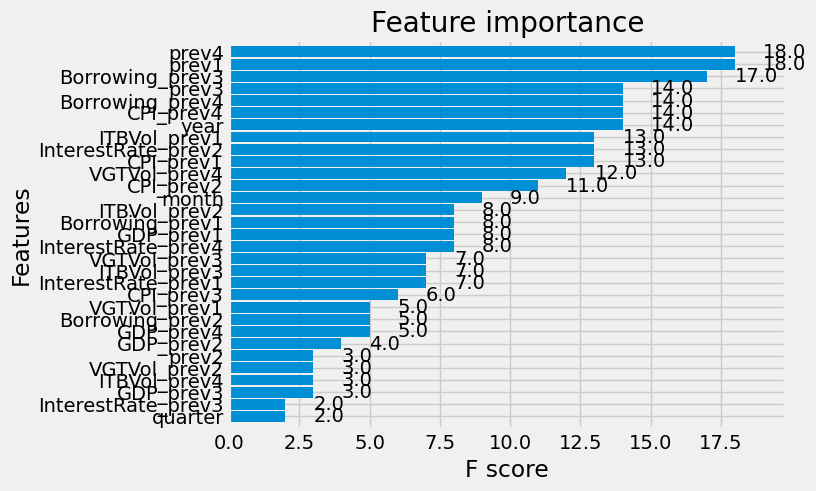

In [103]:
#Plot of feature importance
_ = plot_importance(reg, height=0.9)

In [104]:
#Predicting with our model for both the train and test data
train_ml["Predictions"] = reg.predict(X_train)
test_ml['Prediction'] = reg.predict(X_test)

In [105]:
#Plotting the predictions of the training data
XGBoost_and_rolling = pd.concat([pd.DataFrame(list(train_ml["Predictions"]),list(train_ml["Construction"]))], axis=1).dropna().reset_index()
XGBoost_and_rolling.rename(columns={"index":"Real_Construction",0:"Predicted Construction"}, inplace=True)
XGBoost_and_rolling = px.line(XGBoost_and_rolling, title = 'XGBOOST vs Construction TRAIN', width=1000, height=500)
XGBoost_and_rolling.show()

In [106]:
#Plotting the predictions of the testing data
XGBoost_and_rolling = pd.concat([pd.DataFrame(list(test_ml["Prediction"]),list(test_ml["Construction"]))], axis=1).dropna().reset_index()
XGBoost_and_rolling.rename(columns={"index":"Real_Construction",0:"Predicted Construction"}, inplace=True)
XGBoost_and_rolling = px.line(XGBoost_and_rolling, title = 'XGBOOST vs Construction TEST', width=1000, height=500)
XGBoost_and_rolling.show()

In [107]:
pred_sign = np.sign(train_ml['Predictions'])
y_test_sign = np.sign(train_ml['Construction'])
classification_accuracy = 1 - 0.5*np.sum(np.abs(pred_sign - y_test_sign))/np.size(y_test_sign)
classification_accuracy

0.9577464788732395

In [108]:
pred_sign = np.sign(test_ml['Prediction'])
y_test_sign = np.sign(test_ml['Construction'])
classification_accuracy = 1 - 0.5*np.sum(np.abs(pred_sign - y_test_sign))/np.size(y_test_sign)
classification_accuracy

0.8548387096774194

Metrics:


Root Mean Square Error, RMSE: Square root of the mean of the difference between the actual data points and the squared prediction value. It penalizes greater or extreme differences more.

Mean Absolute Percentage Error, MAPE: It allows to measure errors relative to the magnitude of the real value.

In [109]:
RMSE_Serie_XG = mean_squared_error(train_ml["Construction"],train_ml["Predictions"],squared=False)
MAPE_Serie_XG = mean_absolute_percentage_error(train_ml["Construction"], train_ml["Predictions"])
print(f"The RMSE of our XGBOOST model in the full serie data is {round(RMSE_Serie_XG,4)}")
print(f"The MAPE of our XGBOOST model in the full serie data is {round(MAPE_Serie_XG*100,2)}%")

The RMSE of our XGBOOST model in the full serie data is 0.0016
The MAPE of our XGBOOST model in the full serie data is 47.08%


In [110]:
true_vol = test_ml['Prediction']
pred_vol = test_ml["Construction"]
RMSE_XG = mean_squared_error(true_vol, pred_vol,squared=False)
MAPE_XG = mean_absolute_percentage_error(true_vol, pred_vol)
print(f"The RMSE of our XGBOOST model in the predicted data is {round(RMSE_XG,4)}")
print(f"The MAPE of our XGBOOST model in the predicted data is {round(MAPE_XG*100,2)}%")

The RMSE of our XGBOOST model in the predicted data is 0.0043
The MAPE of our XGBOOST model in the predicted data is 166.26%


In [111]:
X, y = create_features(const_data, label="Construction")
const_data["Predictions"] = reg.predict(X)
#Plotting the predictions of the training data
XGBoost_and_rolling = pd.concat([pd.DataFrame(list(const_data["Predictions"]),list(const_data["Construction"]))], axis=1).dropna().reset_index()
XGBoost_and_rolling.rename(columns={"index":"Real_Construction",0:"Predicted Construction"}, inplace=True)
XGBoost_and_rolling = px.line(XGBoost_and_rolling, title = 'XGBOOST vs Construction FULL', width=1000, height=500)
XGBoost_and_rolling.show()

In [112]:
pred_sign = np.sign(const_data['Predictions'])
y_test_sign = np.sign(const_data['Construction'])
classification_accuracy = 1 - 0.5*np.sum(np.abs(pred_sign - y_test_sign))/np.size(y_test_sign)
classification_accuracy

0.9264705882352942

In [113]:
true_vol = const_data['Predictions']
pred_vol = const_data["Construction"]
RMSE_XG = mean_squared_error(true_vol, pred_vol,squared=False)
MAPE_XG = mean_absolute_percentage_error(true_vol, pred_vol)
print(f"The RMSE of our XGBOOST model in the predicted data is {round(RMSE_XG,4)}")
print(f"The MAPE of our XGBOOST model in the predicted data is {round(MAPE_XG*100,2)}%")
r2_score = sklearn.metrics.r2_score(true_vol, pred_vol)
print(f"The R^2 score of our XGBOOST model in the predicted data is {round(r2_score,4)}")

The RMSE of our XGBOOST model in the predicted data is 0.0027
The MAPE of our XGBOOST model in the predicted data is 78.86%
The R^2 score of our XGBOOST model in the predicted data is 0.6846


# Prediction for Information

In [117]:
fig = px.line(outputs['Information'], width=1000, height=500)
fig.update_layout(title_text='Monthly employment data of Information from 2006-06-01 to 2023-09-01')
fig.show()

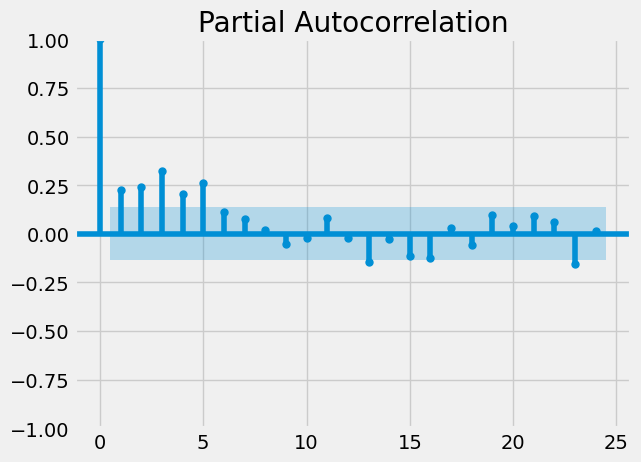

In [118]:
plot_pacf(outputs['Information'],method="yw")
#Print the visualization
plt.show()

In [281]:
info_data = outputs[['Month','Information']]
#Convert the date column to datetime format
info_data["Month"] = pd.to_datetime(info_data["Month"])
for i in range(1,6):
    info_data['prev'+str(i)]=info_data['Information'].shift(i)
train_ml, test_ml, y_train, y_test = train_test_split(info_data, info_data['Information'], test_size=0.35, random_state=0)
train_ml.head()

,Month,Information,prev1,prev2,prev3,prev4,prev5
92,2014-02-01,-0.002203,-0.001100,0.001837,0.001472,0.003693,0.006317
101,2014-11-01,0.002934,-0.002560,0.000366,0.002936,0.001102,0.001840
126,2016-12-01,0.001778,-0.000711,-0.001065,0.004995,0.001429,-0.000714
145,2018-07-01,0.001057,-0.001056,0.001057,0.004246,0.002483,0.000710
138,2017-12-01,0.001066,0.001423,-0.001776,0.001066,0.001424,-0.000711


In [282]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['quarter'] = df['Month'].dt.quarter
    df['month'] = df['Month'].dt.month
    df['year'] = df['Month'].dt.year
    for i in range(2,N):
        df[inputs.keys()[i]] = inputs.iloc[:,i]
    features = ['quarter','month','year']
    input_feat = ['CPI', 'InterestRate', 'GDP','Borrowing', 'ITBVol', 'VGTVol']
    for feature in input_feat:
        for i in range(1,6):
            features.append(feature+'_prev'+str(i))
#     features = ['quarter','month','year', 'prev1', 'prev3', 'prev4', 'InterestRate_prev2', 'Borrowing_prev3', 'Borrowing_prev4','VGTVol_prev3', 'VGTVol_prev4', 'CPI_prev1', 'CPI_prev2', 'CPI_prev4', 'ITBVol_prev1']
#     X = df[features]
    # X = df[['quarter','month','year']]
    # X = df[['quarter','month','year','CPI', 'InterestRate', 'GDP', 'ValAddConst', 'ValAddInfo','Borrowing','CommercialLoan', 'ConsumerLoan','Deficit','ITBPrice', 'ITBVol','VGTPrice', 'VGTVol','S&P500Price','S&P500Vol']]
    # X = df[['quarter','CPI', 'InterestRate','CommercialLoan', 'ConsumerLoan','Deficit','ITBPrice', 'VGTVol','S&P500Price','S&P500Vol']]
#     X = df[['quarter','month','year','CPI', 'InterestRate', 'GDP','Borrowing','CommercialLoan', 'ConsumerLoan','Deficit','ITBPrice','VGTPrice','S&P500Price']]
#     features = ['quarter','year','CPI', 'InterestRate', 'GDP','CommercialLoan', 'ConsumerLoan','ITBPrice', 'ITBVol', 'VGTVol']
    for i in range(1,6):
        features.append('prev'+str(i))
    X = df[features]
    if label:
        y = df[label]
        return X, y
    return X

In [283]:
#Creating the features for the train and test sets
X_train, y_train = create_features(train_ml, label="Information")
X_test, y_test = create_features(test_ml, label="Information")
X_train.head()

,quarter,month,year,CPI_prev1,CPI_prev2,CPI_prev3,CPI_prev4,CPI_prev5,InterestRate_prev1,InterestRate_prev2,...,VGTVol_prev1,VGTVol_prev2,VGTVol_prev3,VGTVol_prev4,VGTVol_prev5,prev1,prev2,prev3,prev4,prev5
92,1,2,2014,0.001845,0.000535,0.000377,0.002387,0.001958,0.125000,-0.111111,...,0.707137,0.133106,-0.395012,0.028967,0.664719,-0.001100,0.001837,0.001472,0.003693,0.006317
101,4,11,2014,-0.000160,0.001125,0.001321,0.001903,0.001864,0.000000,0.000000,...,0.452660,-0.046603,0.165796,-0.031706,-0.043425,-0.002560,0.000366,0.002936,0.001102,0.001840
126,4,12,2016,0.002623,0.001849,-0.000504,0.002776,0.002364,0.000000,0.000000,...,0.326008,-0.245662,0.915621,-0.365584,0.236364,-0.000711,-0.001065,0.004995,0.001429,-0.000714
145,3,7,2018,0.002604,0.000192,0.002692,0.004253,0.002107,0.005917,0.119205,...,0.334181,-0.135565,-0.465054,0.024057,0.494489,-0.001056,0.001057,0.004246,0.002483,0.000710
138,4,12,2017,0.005106,0.003849,0.000328,0.000652,-0.000774,0.000000,-0.008621,...,-0.029306,0.169552,0.118864,-0.193268,-0.194070,0.001423,-0.001776,0.001066,0.001424,-0.000711


In [284]:
#Defining and fitting the model
reg = xgb.XGBRegressor(n_estimators=1000,early_stopping_rounds=60,)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=60,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

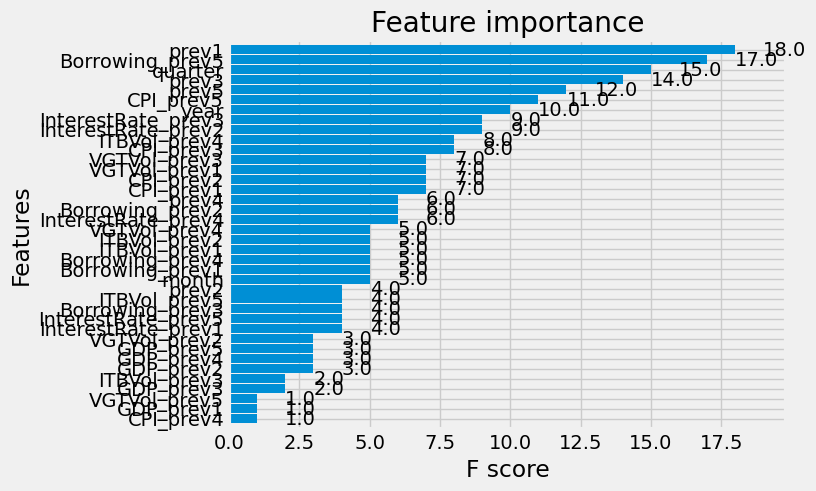

In [285]:
#Plot of feature importance
_ = plot_importance(reg, height=0.9)

In [286]:
#Predicting with our model for both the train and test data
train_ml["Predictions"] = reg.predict(X_train)
test_ml['Prediction'] = reg.predict(X_test)

In [287]:
#Plotting the predictions of the training data
XGBoost_and_rolling = pd.concat([pd.DataFrame(list(train_ml["Predictions"]),list(train_ml["Information"]))], axis=1).dropna().reset_index()
XGBoost_and_rolling.rename(columns={"index":"Real_Information",0:"Predicted Information"}, inplace=True)
XGBoost_and_rolling = px.line(XGBoost_and_rolling, title = 'XGBOOST vs Information TRAIN', width=1000, height=500)
XGBoost_and_rolling.show()

In [288]:
#Plotting the predictions of the testing data
XGBoost_and_rolling = pd.concat([pd.DataFrame(list(test_ml["Prediction"]),list(test_ml["Information"]))], axis=1).dropna().reset_index()
XGBoost_and_rolling.rename(columns={"index":"Real_Information",0:"Predicted Information"}, inplace=True)
XGBoost_and_rolling = px.line(XGBoost_and_rolling, title = 'XGBOOST vs Information TEST', width=1000, height=500)
XGBoost_and_rolling.show()

In [289]:
pred_sign = np.sign(train_ml['Predictions'])
y_test_sign = np.sign(train_ml['Information'])
classification_accuracy = 1 - 0.5*np.sum(np.abs(pred_sign - y_test_sign))/np.size(y_test_sign)
classification_accuracy

0.9848484848484849

In [290]:
pred_sign = np.sign(test_ml['Prediction'])
y_test_sign = np.sign(test_ml['Information'])
classification_accuracy = 1 - 0.5*np.sum(np.abs(pred_sign - y_test_sign))/np.size(y_test_sign)
classification_accuracy

0.7222222222222222

In [291]:
RMSE_Serie_XG = mean_squared_error(train_ml["Information"],train_ml["Predictions"],squared=False)
MAPE_Serie_XG = mean_absolute_percentage_error(train_ml["Information"], train_ml["Predictions"])
print(f"The RMSE of our XGBOOST model in the full serie data is {round(RMSE_Serie_XG,4)}")
print(f"The MAPE of our XGBOOST model in the full serie data is {round(MAPE_Serie_XG*100,2)}%")

The RMSE of our XGBOOST model in the full serie data is 0.0005
The MAPE of our XGBOOST model in the full serie data is 1250226672501.8%


In [292]:
true_vol = test_ml['Prediction']
pred_vol = test_ml["Information"]
RMSE_XG = mean_squared_error(true_vol, pred_vol,squared=False)
MAPE_XG = mean_absolute_percentage_error(true_vol, pred_vol)
print(f"The RMSE of our XGBOOST model in the predicted data is {round(RMSE_XG,4)}")
print(f"The MAPE of our XGBOOST model in the predicted data is {round(MAPE_XG*100,2)}%")

The RMSE of our XGBOOST model in the predicted data is 0.0038
The MAPE of our XGBOOST model in the predicted data is 332.85%


In [293]:
X, y = create_features(info_data, label="Information")
info_data["Predictions"] = reg.predict(X)
#Plotting the predictions of the training data
XGBoost_and_rolling = pd.concat([pd.DataFrame(list(info_data["Predictions"]),list(info_data["Information"]))], axis=1).dropna().reset_index()
XGBoost_and_rolling.rename(columns={"index":"Real_Information",0:"Predicted Information"}, inplace=True)
XGBoost_and_rolling = px.line(XGBoost_and_rolling, title = 'XGBOOST vs Information FULL', width=1000, height=500)
XGBoost_and_rolling.show()

In [294]:
pred_sign = np.sign(info_data['Predictions'])
y_test_sign = np.sign(info_data['Information'])
classification_accuracy = 1 - 0.5*np.sum(np.abs(pred_sign - y_test_sign))/np.size(y_test_sign)
classification_accuracy

0.892156862745098

In [295]:
true_vol = info_data['Predictions']
pred_vol = info_data["Information"]
RMSE_XG = mean_squared_error(true_vol, pred_vol,squared=False)
MAPE_XG = mean_absolute_percentage_error(true_vol, pred_vol)
print(f"The RMSE of our XGBOOST model in the predicted data is {round(RMSE_XG,4)}")
print(f"The MAPE of our XGBOOST model in the predicted data is {round(MAPE_XG*100,2)}%")

The RMSE of our XGBOOST model in the predicted data is 0.0023
The MAPE of our XGBOOST model in the predicted data is 132.61%


# Prediction for Total Private

In [296]:
fig = px.line(outputs['Total_Private'], width=1000, height=500)
fig.update_layout(title_text='Monthly employment data of Total_Private from 2006-06-01 to 2023-09-01')
fig.show()

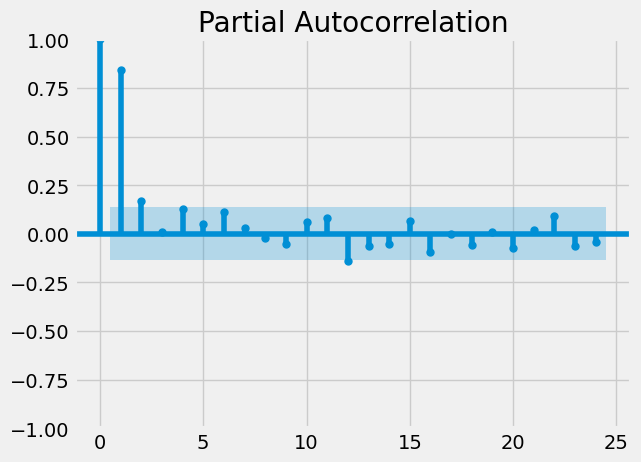

In [297]:
plot_pacf(outputs['Total_Private'],method="yw")
#Print the visualization
plt.show()

In [389]:
totpriv_data = outputs[['Month','Total_Private']]
#Convert the date column to datetime format
totpriv_data["Month"] = pd.to_datetime(totpriv_data["Month"])
for i in range(1,6):
    totpriv_data['prev'+str(i)]=totpriv_data['Total_Private'].shift(i)
train_ml, test_ml, y_train, y_test = train_test_split(totpriv_data, totpriv_data['Total_Private'], test_size=0.3, random_state=4)

In [390]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['quarter'] = df['Month'].dt.quarter
    df['month'] = df['Month'].dt.month
    df['year'] = df['Month'].dt.year
    for i in range(2,N):
        df[inputs.keys()[i]] = inputs.iloc[:,i]
    features = ['year']
    input_feat = ['CommercialLoan','VGTPrice','CPI']
    for feature in input_feat:
        for i in range(1,3):
            features.append(feature+'_prev'+str(i))
    for i in range(1,3):
        features.append('prev'+str(i))
    X = df[features]
    # X = df[['quarter','month','year']]
#     X = df[['year','CommercialLoan','VGTPrice', 'CPI']]
    # X = df[['quarter','month','year','CPI', 'InterestRate', 'GDP', 'ValAddConst', 'ValAddInfo','Borrowing','CommercialLoan', 'ConsumerLoan','Deficit','ITBPrice', 'ITBVol','VGTPrice', 'VGTVol','S&P500Price','S&P500Vol']]
    if label:
        y = df[label]
        return X, y
    return X

In [391]:
#Creating the features for the train and test sets
X_train, y_train = create_features(train_ml, label="Total_Private")
X_test, y_test = create_features(test_ml, label="Total_Private")
X_train.head()

,year,CommercialLoan_prev1,CommercialLoan_prev2,VGTPrice_prev1,VGTPrice_prev2,CPI_prev1,CPI_prev2,prev1,prev2
130,2017,-0.008,-0.031,0.026897,0.045877,0.004043,0.002524,0.001028,0.001589
199,2023,-0.028,0.032,0.042464,0.007596,0.003700,0.005171,0.001347,0.001183
5,2006,0.222,0.177,0.044646,0.066667,0.004436,0.005451,0.000331,0.000567
186,2022,0.057,0.192,-0.028115,-0.035842,0.006095,0.007807,0.003281,0.007006
25,2008,0.157,0.175,-0.012655,0.064947,0.002314,0.003578,-0.001664,-0.001938


In [392]:
#Defining and fitting the model
reg = xgb.XGBRegressor(n_estimators=1000,early_stopping_rounds=60,)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=60,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

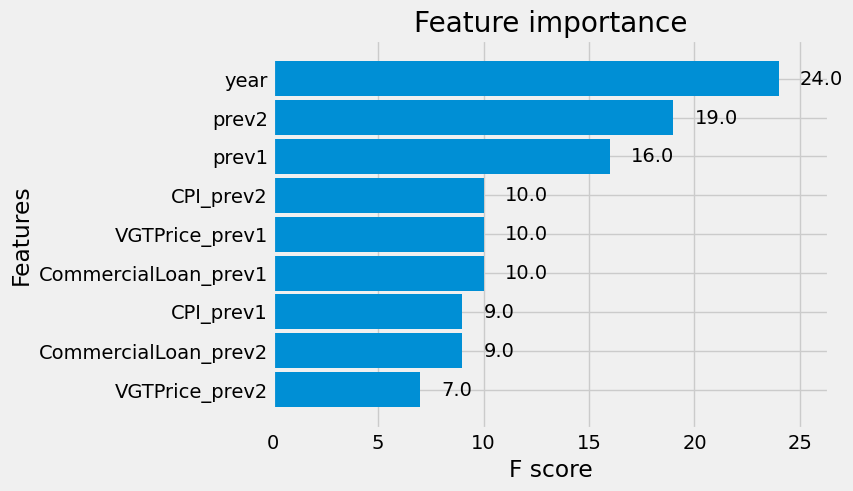

In [393]:
#Plot of feature importance
_ = plot_importance(reg, height=0.9)

In [394]:
#Predicting with our model for both the train and test data
train_ml["Predictions"] = reg.predict(X_train)
test_ml['Prediction'] = reg.predict(X_test)

In [395]:
#Plotting the predictions of the training data
XGBoost_and_rolling = pd.concat([pd.DataFrame(list(train_ml["Predictions"]),list(train_ml["Total_Private"]))], axis=1).dropna().reset_index()
XGBoost_and_rolling.rename(columns={"index":"Real_Total_Private",0:"Predicted Total_Private"}, inplace=True)
XGBoost_and_rolling = px.line(XGBoost_and_rolling, title = 'XGBOOST vs Total_Private TRAIN', width=1000, height=500)
XGBoost_and_rolling.show()

In [396]:
#Plotting the predictions of the testing data
XGBoost_and_rolling = pd.concat([pd.DataFrame(list(test_ml["Prediction"]),list(test_ml["Total_Private"]))], axis=1).dropna().reset_index()
XGBoost_and_rolling.rename(columns={"index":"Real_Total_Private",0:"Predicted Total_Private"}, inplace=True)
XGBoost_and_rolling = px.line(XGBoost_and_rolling, title = 'XGBOOST vs Total_Private TEST', width=1000, height=500)
XGBoost_and_rolling.show()

In [397]:
pred_sign = np.sign(train_ml['Predictions'])
y_test_sign = np.sign(train_ml['Total_Private'])
classification_accuracy = 1 - 0.5*np.sum(np.abs(pred_sign - y_test_sign))/np.size(y_test_sign)
classification_accuracy

0.9929577464788732

In [398]:
pred_sign = np.sign(test_ml['Prediction'])
y_test_sign = np.sign(test_ml['Total_Private'])
classification_accuracy = 1 - 0.5*np.sum(np.abs(pred_sign - y_test_sign))/np.size(y_test_sign)
classification_accuracy

0.9516129032258065

In [399]:
RMSE_Serie_XG = mean_squared_error(train_ml["Total_Private"],train_ml["Predictions"],squared=False)
MAPE_Serie_XG = mean_absolute_percentage_error(train_ml["Total_Private"], train_ml["Predictions"])
print(f"The RMSE of our XGBOOST model in the full serie data is {round(RMSE_Serie_XG,4)}")
print(f"The MAPE of our XGBOOST model in the full serie data is {round(MAPE_Serie_XG*100,2)}%")

The RMSE of our XGBOOST model in the full serie data is 0.0005
The MAPE of our XGBOOST model in the full serie data is 40.54%


In [400]:
true_vol = test_ml['Prediction']
pred_vol = test_ml["Total_Private"]
RMSE_XG = mean_squared_error(true_vol, pred_vol,squared=False)
MAPE_XG = mean_absolute_percentage_error(true_vol, pred_vol)
print(f"The RMSE of our XGBOOST model in the predicted data is {round(RMSE_XG,4)}")
print(f"The MAPE of our XGBOOST model in the predicted data is {round(MAPE_XG*100,2)}%")

The RMSE of our XGBOOST model in the predicted data is 0.0012
The MAPE of our XGBOOST model in the predicted data is 68.93%


In [401]:
X, y = create_features(totpriv_data, label="Total_Private")
totpriv_data["Predictions"] = reg.predict(X)
#Plotting the predictions of the training data
XGBoost_and_rolling = pd.concat([pd.DataFrame(list(totpriv_data["Predictions"]),list(totpriv_data["Total_Private"]))], axis=1).dropna().reset_index()
XGBoost_and_rolling.rename(columns={"index":"Real_Total_Private",0:"Predicted Total_Private"}, inplace=True)
XGBoost_and_rolling = px.line(XGBoost_and_rolling, title = 'XGBOOST vs Total_Private FULL', width=1000, height=500)
XGBoost_and_rolling.show()

In [402]:
pred_sign = np.sign(totpriv_data['Predictions'])
y_test_sign = np.sign(totpriv_data['Total_Private'])
classification_accuracy = 1 - 0.5*np.sum(np.abs(pred_sign - y_test_sign))/np.size(y_test_sign)
classification_accuracy

0.9803921568627451

In [403]:
true_vol = totpriv_data['Predictions']
pred_vol = totpriv_data["Total_Private"]
RMSE_XG = mean_squared_error(true_vol, pred_vol,squared=False)
MAPE_XG = mean_absolute_percentage_error(true_vol, pred_vol)
print(f"The RMSE of our XGBOOST model in the predicted data is {round(RMSE_XG,4)}")
print(f"The MAPE of our XGBOOST model in the predicted data is {round(MAPE_XG*100,2)}%")
r2_score = sklearn.metrics.r2_score(true_vol, pred_vol)
print(f"The R^2 score of our XGBOOST model in the predicted data is {round(r2_score,4)}")

The RMSE of our XGBOOST model in the predicted data is 0.0008
The MAPE of our XGBOOST model in the predicted data is 75.01%
The R^2 score of our XGBOOST model in the predicted data is 0.8575
